In [9]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [12]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model

# reflect the tables


In [13]:
# Declare a Base using "automap_base()"
Base = automap_base()

In [14]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [20]:
# Display the row's columns and data in dictionary format (Measurement)
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fba5036ec50>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [23]:
# Inspect data in columns to determine data types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
# Find the most recent date in the data set.
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 10').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

One Year Prior: 2016-08-23


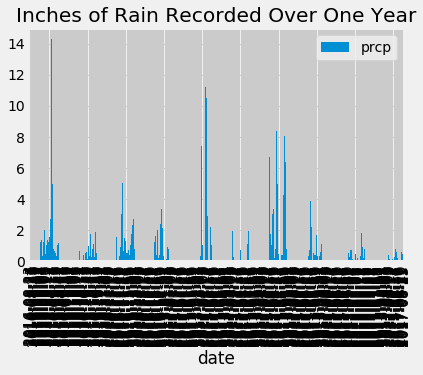

<Figure size 432x288 with 0 Axes>

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) -  dt.timedelta(days=365)
print(f"One Year Prior: {year_ago}")

# Perform a query to retrieve the data and precipitation scores
one_year = engine.execute("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23'")\
.fetchall()
#one_year

# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_df = pd.DataFrame(data = one_year, columns=["date", "prcp"]).set_index("date")
one_year_df = one_year_df.groupby(["date"]).sum()
#one_year_df

# Sort the dataframe by date
one_year_df = one_year_df.sort_values("date")
# one_year_df

# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(kind="bar")

plt.title("Inches of Rain Recorded Over One Year")
plt.xticks()
#plt.xticks(ticks=[0, 40, 80, 120, 160, 200, 240, 280, 320, 360], labels=["2016-08-23", "2016-10-01", "2016-11-09", "2016-12-19", "2017-01-28", "2017-03-09", "2017-04-18", "2017-05-31", "2017-07-10"])
plt.show()
plt.tight_layout()


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [19]:
# Display the row's columns and data in dictionary format (Station)
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fba5036e2d0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()